Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Python. Uczenie maszynowe - kod źródłowy

# Rozdział 4. Tworzenie dobrych zestawów danych uczących — wstępne przetwarzanie danych

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -p numpy,pandas,matplotlib,sklearn

Sebastian Raschka 
last updated: 2019-12-04 

numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.1
sklearn 0.22


*Korzystanie z rozszerzenia `watermark` nie jest obowiązkowe. Możesz je zainstalować za pomocą polecenia:*  

    conda install watermark -c conda-forge  

lub  

    pip install watermark   

*Więcej informacji znajdziesz pod adresem: https://github.com/rasbt/watermark.*

<br>
<br>

### Spis treści

- [Kwestia brakujących danych](#Kwestia-brakujących-danych)
  - [Wykrywanie brakujących wartości w danych tabelarycznych](#Wykrywanie-brakujących-wartości-w-danych-tabelarycznych)
  - [Usuwanie przykładów uczących lub cech niezawierających wartości](#Usuwanie-przykładów-uczących-lub-cech-niezawierających-wartości)
  - [Wstawianie brakujących danych](#Wstawianie-brakujących-danych)
  - [Estymatory interfejsu scikit-learn](#Estymatory-interfejsu-scikit-learn)
- [Przetwarzanie danych kategorialnych](#Przetwarzanie-danych-kategorialnych)
  - [Cechy nominalne i porządkowe](#Cechy-nominalne-i-porządkowe)
  - [Mapowanie cech porządkowych](#Mapowanie-cech-porządkowych)
  - [Kodowanie etykiet klas](#Kodowanie-etykiet-klas)
  - [Kodowanie „gorącojedynkowe” cech nominalnych](#Kodowanie-„gorącojedynkowe”-cech-nominalnych)
- [Rozdzielanie zestawu danych na oddzielne podzbiory uczące i testowe](#Rozdzielanie-zestawu-danych-na-oddzielne-podzbiory-uczące-i-testowe)
- [Skalowanie cech](#Skalowanie-cech)
- [Dobór odpowiednich cech](#Dobór-odpowiednich-cech)
  - [Regularyzacje L1 i L2 jako kary ograniczające złożoność modelu](#Regularyzacje-L1-i-L2-jako-kary-ograniczające-złożoność-modelu)
  - [Interpretacja geometryczna regularyzacji L2](#Interpretacja-geometryczna-regularyzacji-L2)
  - [Rozwiązania rzadkie za pomocą regularyzacji L1](#Rozwiązania-rzadkie-za-pomocą-regularyzacji-L1)
  - [Algorytmy sekwencyjnego wyboru cech](#Algorytmy-sekwencyjnego-wyboru-cech)
- [Ocenianie istotności cech za pomocą algorytmu losowego lasu](#Ocenianie-istotności-cech-za-pomocą-algorytmu-losowego-lasu)
- [Podsumowanie](#Podsumowanie)

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

# Kwestia brakujących danych

## Wykrywanie brakujących wartości w danych tabelarycznych

In [3]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# jeżeli korzystasz ze środowiska Python 2.7, musisz
# przekonwertować ciąg znaków do standardu unicode:

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
# uzyskujemy dostęp do tablicy NumPy
# za pomocą atrybutu `values`
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

<br>
<br>

## Usuwanie przykładów uczących lub cech niezawierających wartości

In [6]:
# usuwa wiersze, w których brakuje wartości

df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# usuwa kolumny, w których brakuje wartości

df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [9]:
# usuwa jedynie wiersze, w których wszystkie kolumny mają wartość NaN

df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [10]:
# usuwa wiersze, w których znajduje się mniej, niż trzy wartości rzeczywiste 

df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [11]:
# usuwa jedynie wiersze, dla których wartość NaN pojawia się w określonych kolumnach (tutaj w kolumnie 'C')

df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


<br>
<br>

## Wstawianie brakujących danych

In [12]:
# nasza pierwotna tablica
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [13]:
# wstawia brakujące wartości wykorzystując średnią z kolumny

from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

<br>
<br>

In [14]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Estymatory interfejsu scikit-learn

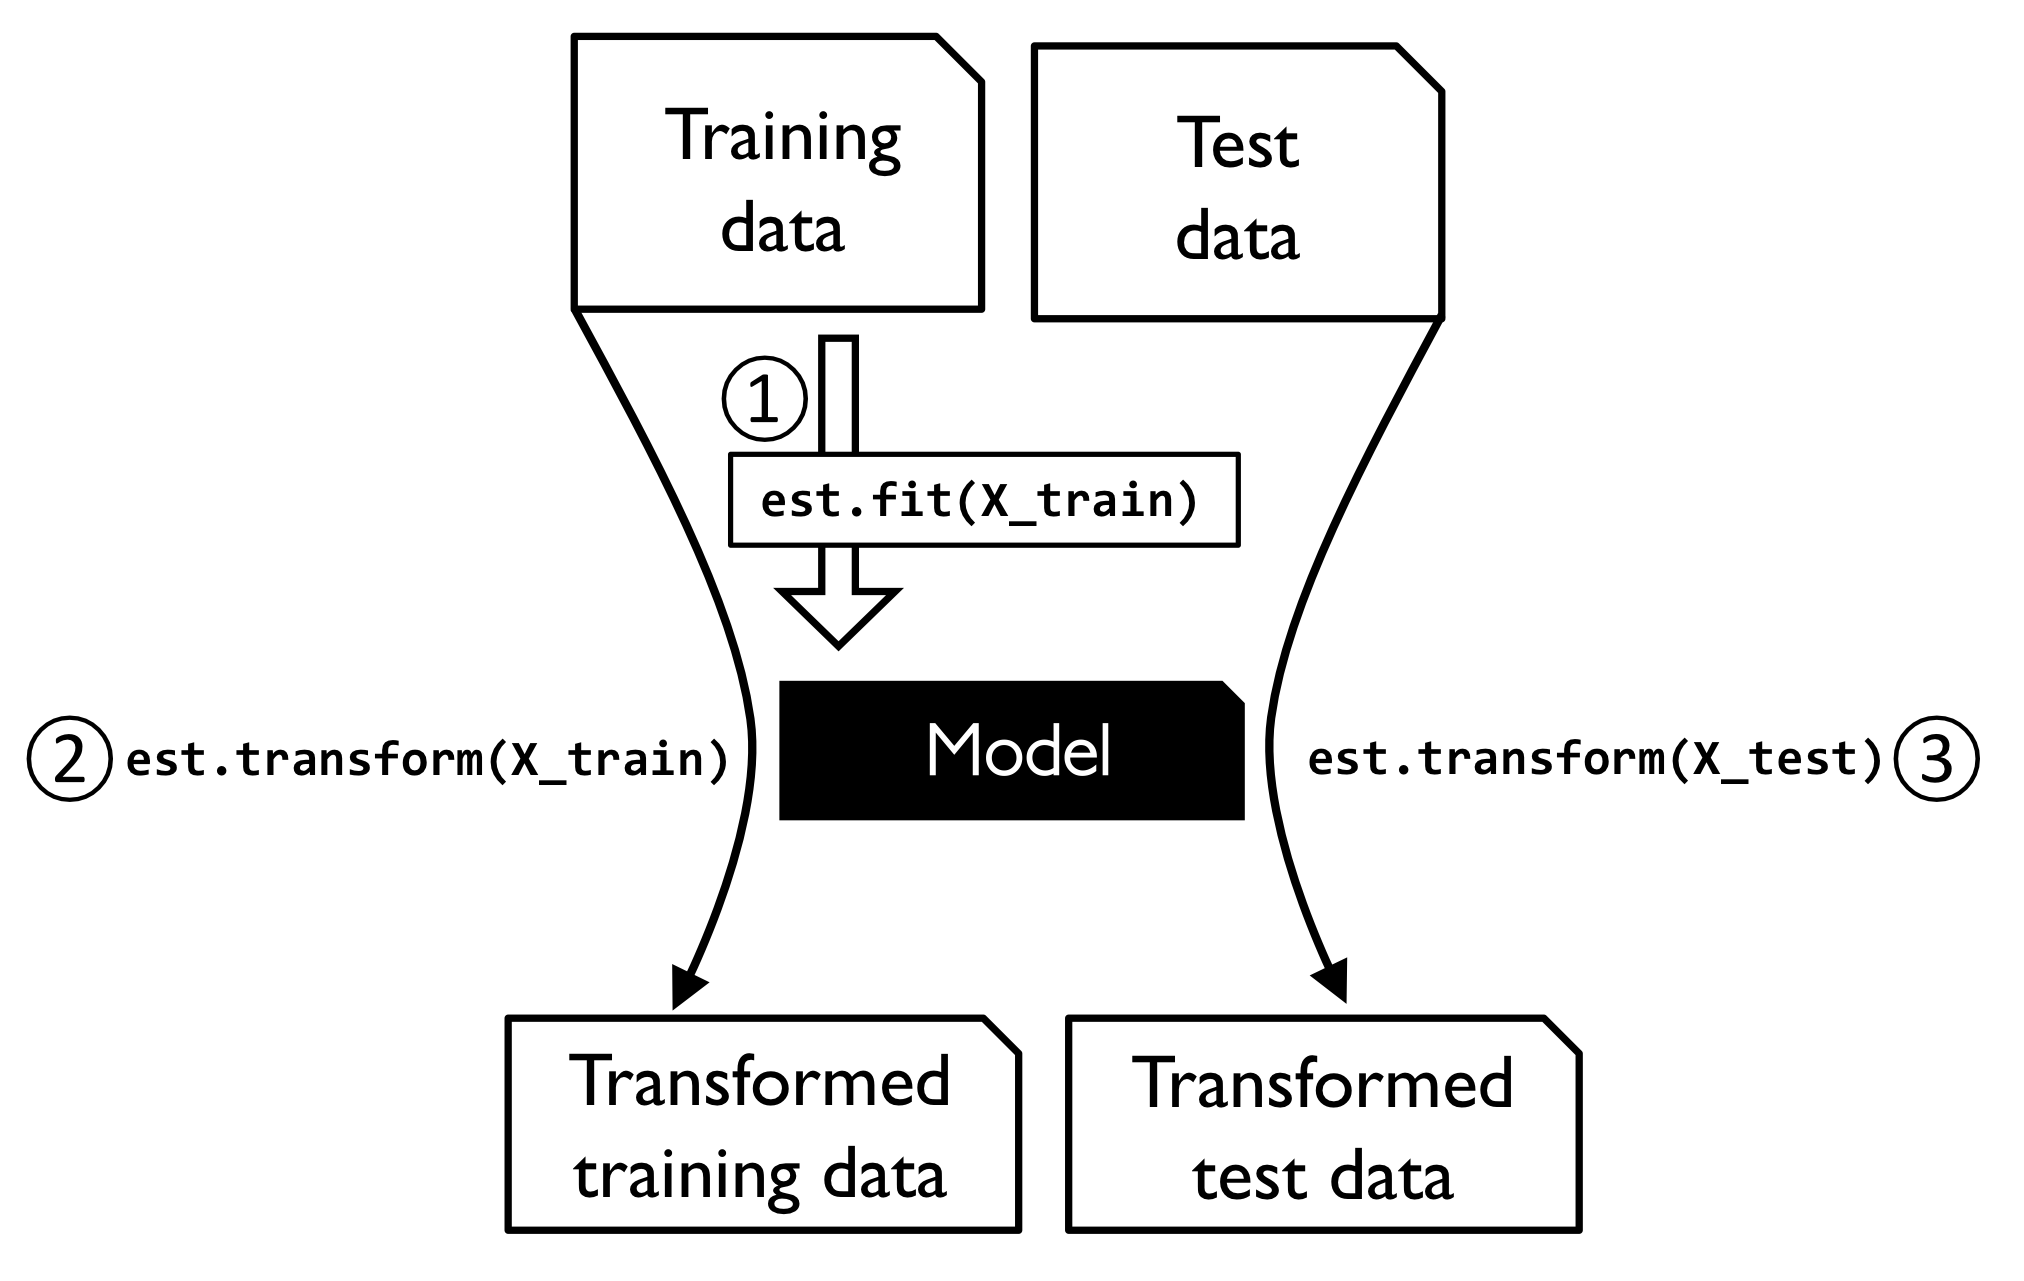

In [2]:
Image(filename='rysunki/04_01.png', width=400) 

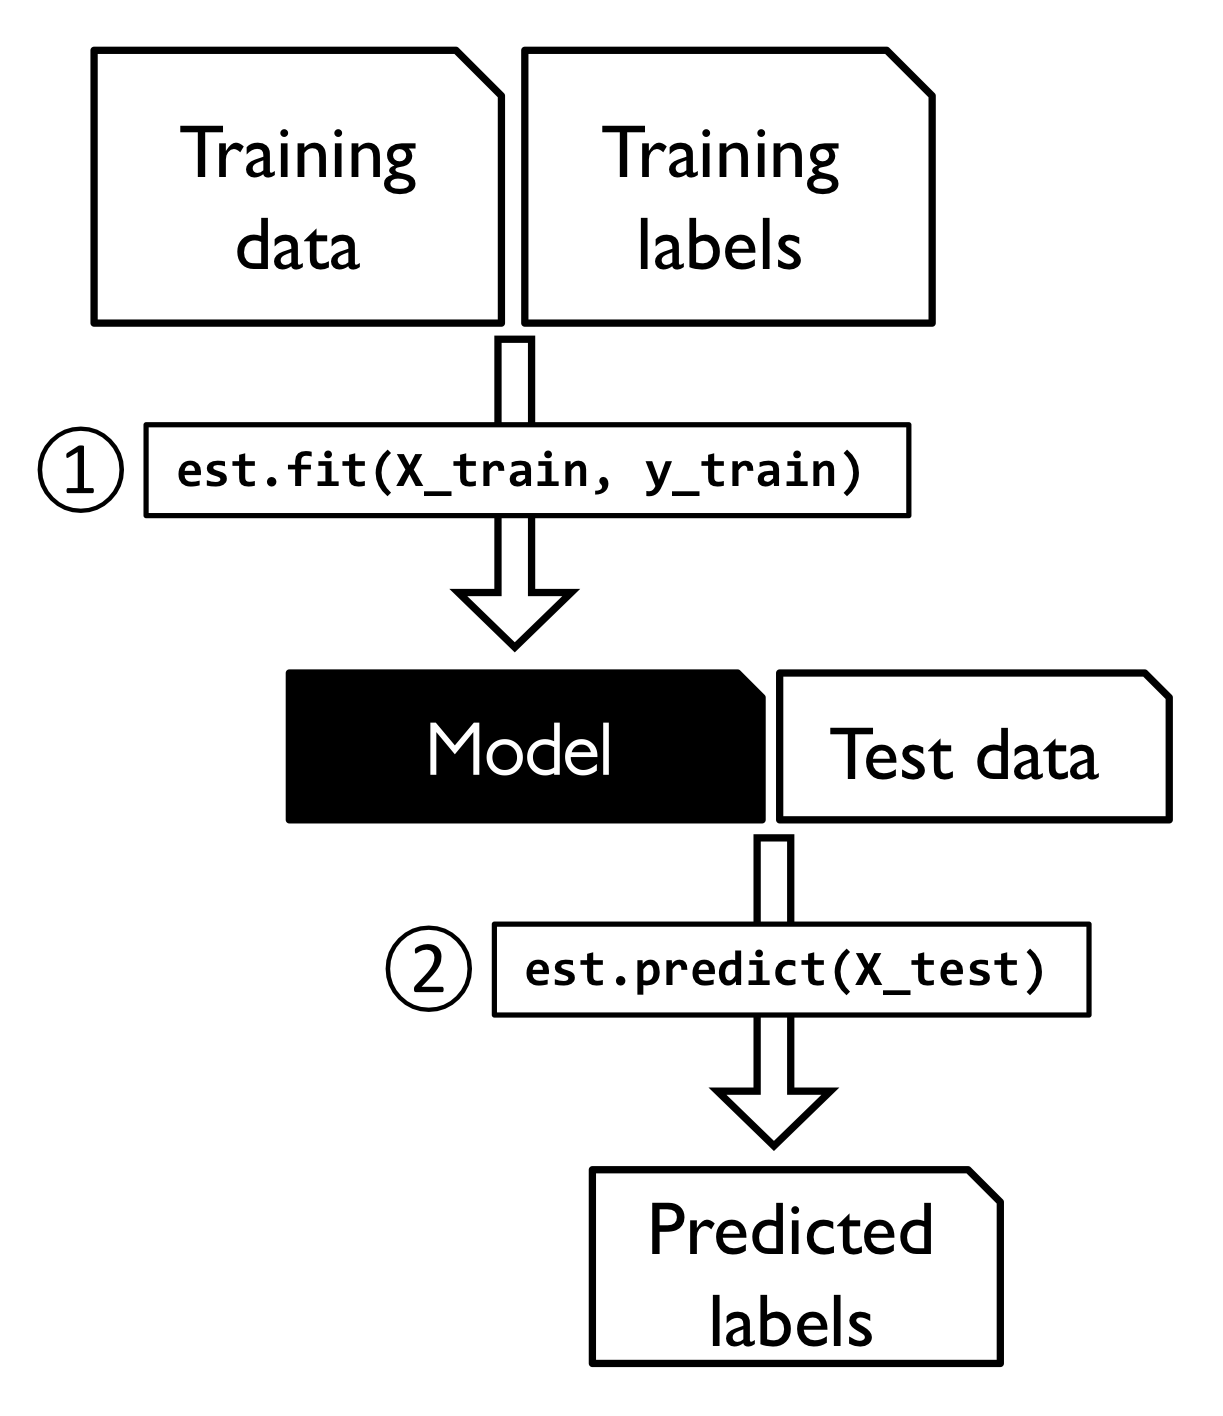

In [3]:
Image(filename='rysunki/04_02.png', width=300) 

<br>
<br>

# Przetwarzanie danych kategorialnych

## Cechy nominalne i porządkowe

In [17]:
import pandas as pd

df = pd.DataFrame([['Zielony', 'M', 10.1, 'klasa2'],
                   ['Czerwony', 'L', 13.5, 'klasa1'],
                   ['Niebieski', 'XL', 15.3, 'klasa2']])

df.columns = ['Kolor', 'Rozmiar', 'Cena', 'Etykieta klas']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


<br>
<br>

## Mapowanie cech porządkowych

In [18]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['Rozmiar'] = df['Rozmiar'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [19]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['Rozmiar'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

<br>
<br>

## Kodowanie etykiet klas

In [20]:
import numpy as np

# tworzy słownik mapowania
# przekształcający etykiety klas z ciągów znaków do postaci liczb całkowitych
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['Etykieta klas']))}
class_mapping

{'class1': 0, 'class2': 1}

In [21]:
# przekształca etykiety klas z ciągów znaków do postaci liczb całkowitych
df['Etykieta klas'] = df['Etykieta klas'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [22]:
# odwraca proces mapowania
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['Etykieta klas'] = df['Etykieta klas'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [23]:
from sklearn.preprocessing import LabelEncoder

# kodowanie etykiet za pomocą klasy LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['Etykieta klas'].values)
y

array([1, 0, 1])

In [24]:
# odwrotne mapowanie
class_le.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)

<br>
<br>

## Kodowanie „gorącojedynkowe” cech nominalnych

In [25]:
X = df[['Kolor', 'Rozmiar', 'Cena']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X


array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [26]:
from sklearn.preprocessing import OneHotEncoder

X = df[['Kolor', 'Rozmiar', 'Cena']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [27]:
from sklearn.compose import ColumnTransformer

X = df[['Kolor', 'Rozmiar', 'Cena']].values
c_transf = ColumnTransformer([ ('onehot', OneHotEncoder(), [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [28]:
# kodowanie gorącojedynkowe za pomocą biblioteki pandas

pd.get_dummies(df[['Kolor', 'Rozmiar', 'Cena']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [29]:
# ochrona współliniowości w funkcji get_dummies

pd.get_dummies(df[['Kolor', 'Rozmiar', 'Cena']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [30]:
# ochrona współiniowości dla klasy OneHotEncoder

color_ohe = OneHotEncoder(categories='auto', drop='first')
c_transf = ColumnTransformer([ ('onehot', color_ohe, [0]),
                               ('nothing', 'passthrough', [1, 2])])
c_transf.fit_transform(X).astype(float)

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

<br>
<br>

## Bonus: kodowanie cech porządkowych

Jeżeli nie jesteśmy pewni różnic numerycznych pomiędzy kategoriami cech porządkowych lub jeśli nie została zdefiniowana różnica pomiędzy dwiema cechami porządkowymi, możemy je kodować za pomocą kodowania progowego przy użyciu wartości 0/1. Na przykład możemy rozdzielić cechę "Rozmiar" mającą wartości M, L i XL na dwie nowe cechy: "x > M" i "x > L". Zacznijmy od naszej pierwotnej ramki danych:

In [31]:
df = pd.DataFrame([['Zielony', 'M', 10.1, 'klasa2'],
                   ['Czerwony', 'L', 13.5, 'klasa1'],
                   ['Niebieski', 'XL', 15.3, 'klasa2']])

df.columns = ['Kolor', 'Rozmiar', 'Cena', 'Etykieta klas']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


Możemy użyć metody `apply` do tworzenia niestandardowych wyrażeń lambda po to, aby kodować te zmienne za pomocą wartości progowych:

In [32]:
df['x > M'] = df['Rozmiar'].apply(lambda x: 1 if x in {'L', 'XL'} else 0)
df['x > L'] = df['Rozmiar'].apply(lambda x: 1 if x == 'XL' else 0)

del df['Rozmiar']
df

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


<br>
<br>

# Rozdzielanie zestawu danych na oddzielne podzbiory uczące i testowe

In [33]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

# jeżeli zestaw danych Wine będzie tymczasowo niedostępny w repozytorium UCI,
# usuń znak komentarza z poniższego wiersza, aby wczytać ten zestaw z katalogu lokalnego:

# df_wine = pd.read_csv('wine.data', header=None)


df_wine.columns = ['Etykieta klas', 'Alkohol', 'Kwas jabłkowy', 'Popiół',
                   'Zasadowość popiołu', 'Magnez', 'Całk. zaw. fenoli',
                   'Flawonoidy', 'Fenole nieflawonoidowe', 'Proantocyjaniny',
                   'Intensywność koloru', 'Odcień', 'Transmitancja 280/315 nm',
                   'Prolina']

print('Etykiety klas', np.unique(df_wine['Etykieta klas']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [34]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

<br>
<br>

# Skalowanie cech

In [35]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [36]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Przykład wizualny:

In [37]:
ex = np.array([0, 1, 2, 3, 4, 5])

print('Standaryzowane:', (ex - ex.mean()) / ex.std())

# Zwróć uwagę, że biblioteka pandas domyślnie wykorzystuje ddof=1 (odchylenie standardowe przykładu), 
# natomiast metoda std i klasa StandardScaler biblioteki NumPy
# używają ddof=0 (odchylenie standardowe populacji)

# normalizuje
print('Normalizowane:', (ex - ex.min()) / (ex.max() - ex.min()))

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


<br>
<br>

# Dobór odpowiednich cech

...

## Regularyzacje L1 i L2 jako kary ograniczające złożoność modelu

## Interpretacja geometryczna regularyzacji L2

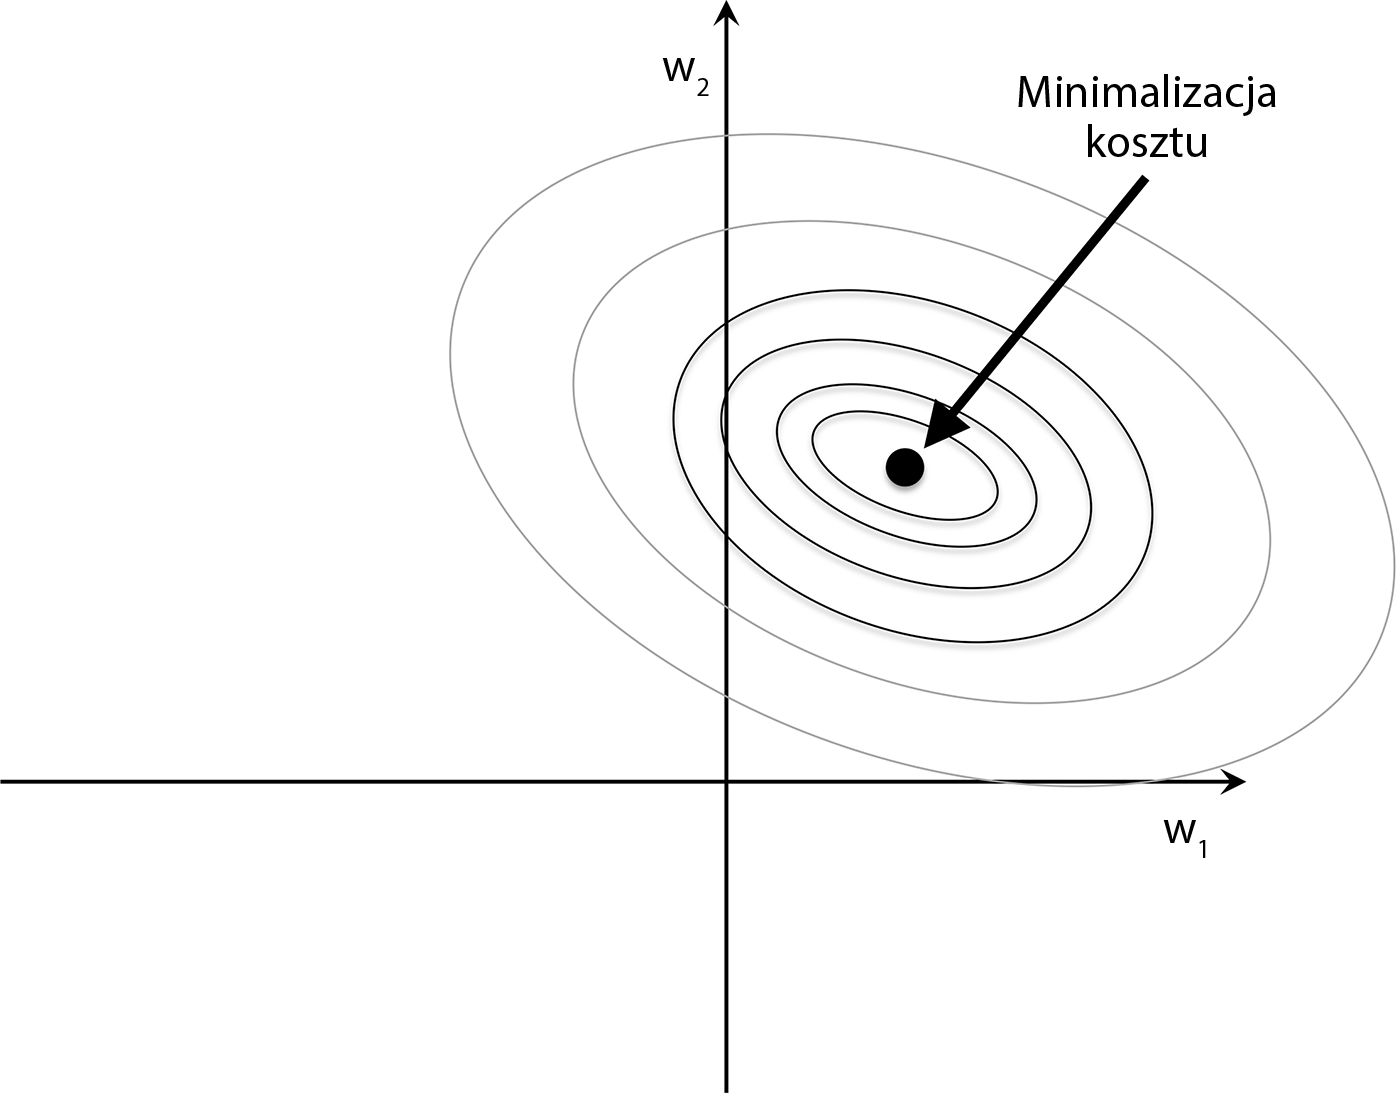

In [4]:
Image(filename='rysunki/04_04.png', width=500) 

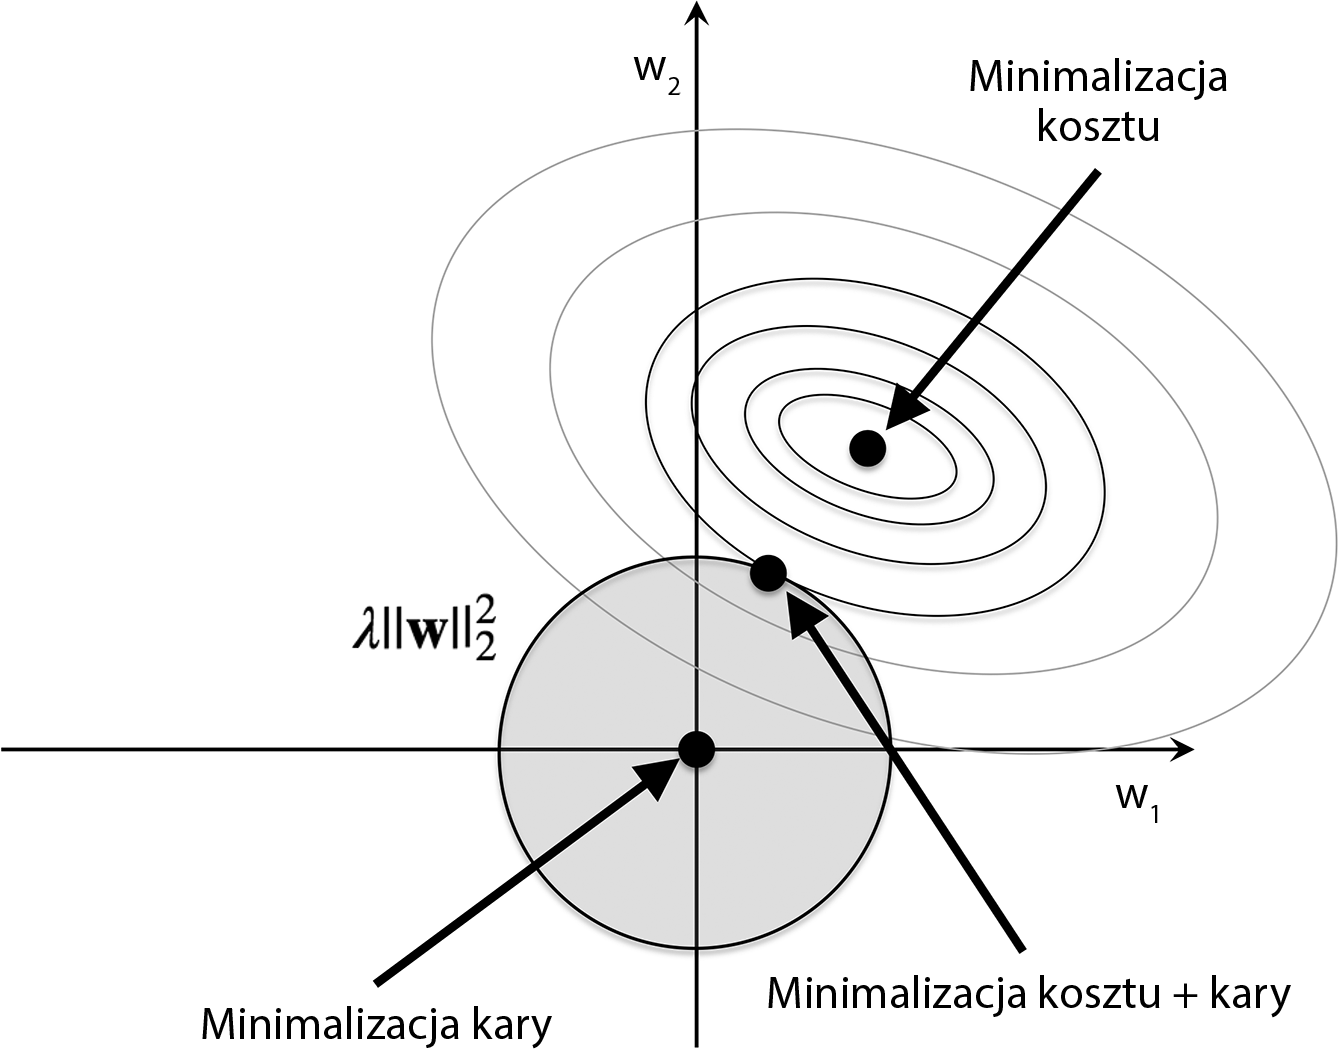

In [5]:
Image(filename='rysunki/04_05.png', width=500) 

## Rozwiązania rzadkie za pomocą regularyzacji L1

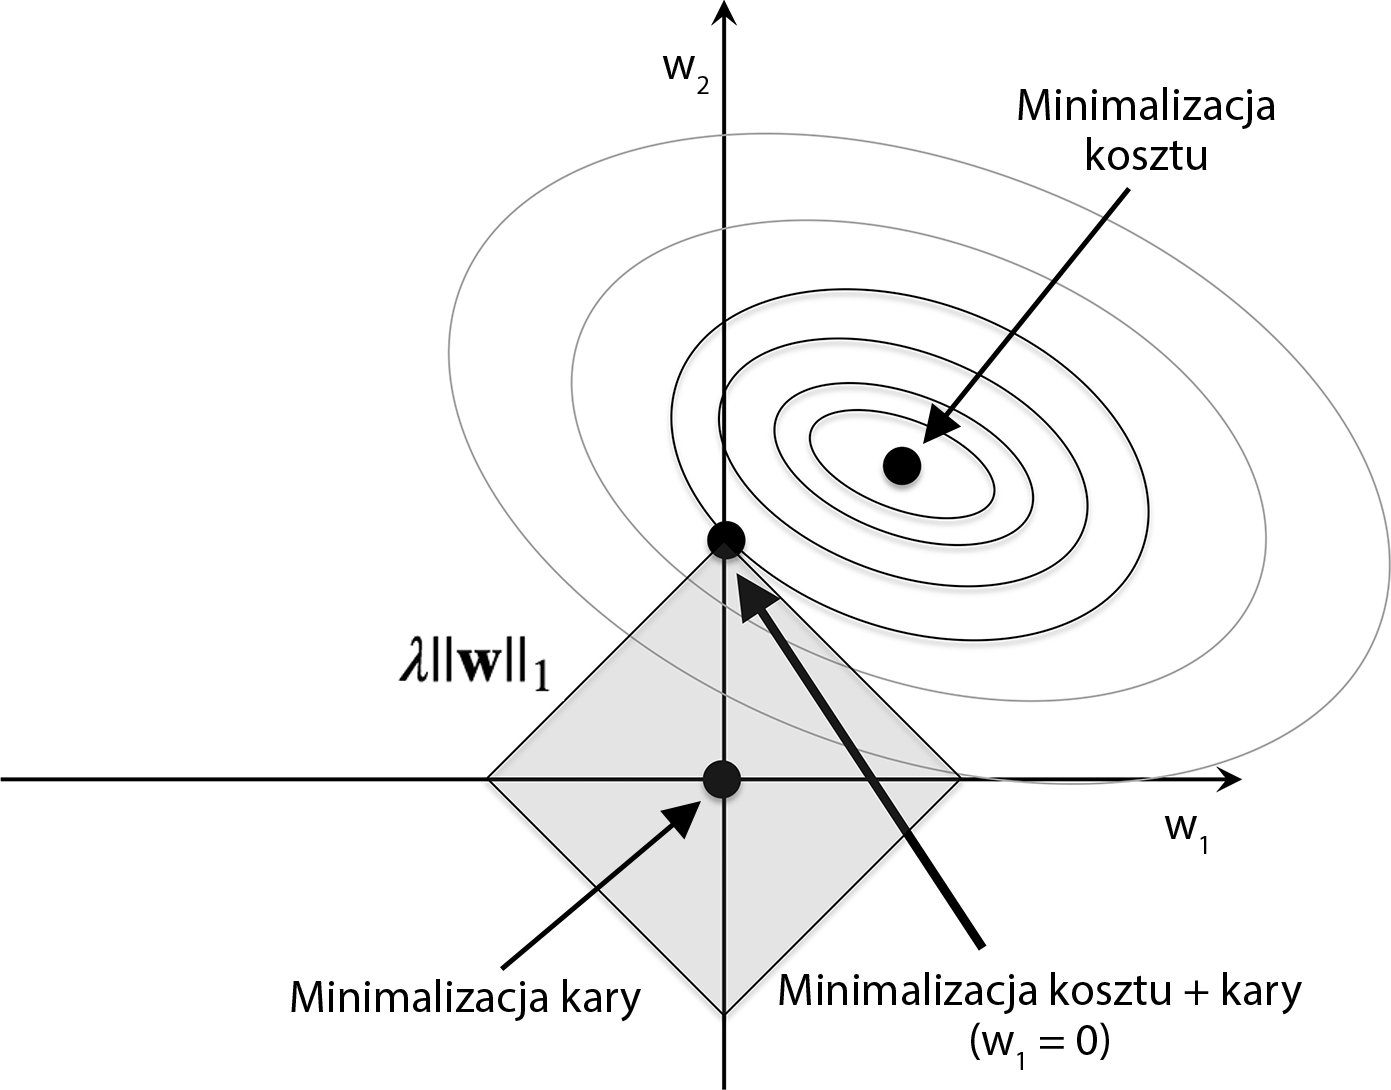

In [6]:
Image(filename='rysunki/04_06.png', width=500) 

W przypadku regularyzowanych modeli wykorzystujących regularyzację L1, możemy wyznaczyć wartość `'l1'` parametru `penalty`, aby uzyskać rozwiązanie rzadkie:

In [41]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Stosujemy wobec standaryzowanych danych Wine ...

In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', multi_class='ovr')
# Wartość C=1.0 jest domyślna. Możesz ją zmniejszać
# lub zwiększać aby, odpowiednio, osłabiać lub wzmacniać
# siłę regularyzacji.
lr.fit(X_train_std, y_train)
print('Dokładność dla danych uczących:', lr.score(X_train_std, y_train))
print('Dokładność dla danych testowych:', lr.score(X_test_std, y_test))

Training accuracy: 1.0
Test accuracy: 1.0


In [43]:
lr.intercept_

array([-1.2633382 , -1.21589578, -2.36999996])

In [44]:
np.set_printoptions(8)

In [45]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [46]:
lr.coef_

array([[ 1.24567193,  0.18059252,  0.7436152 , -1.16126524,  0.        ,
         0.        ,  1.17058952,  0.        ,  0.        ,  0.        ,
         0.        ,  0.54691857,  2.51057502],
       [-1.53780982, -0.38671917, -0.9952918 ,  0.36442868, -0.05924262,
         0.        ,  0.66774065,  0.        ,  0.        , -1.93333009,
         1.23525317,  0.        , -2.23256458],
       [ 0.13537951,  0.16960766,  0.35751869,  0.        ,  0.        ,
         0.        , -2.43327552,  0.        ,  0.        ,  1.56221192,
        -0.81849722, -0.49599876,  0.        ]])

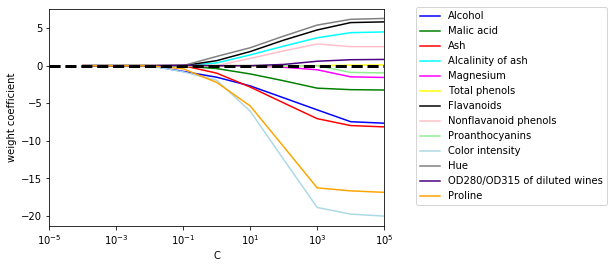

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('Współczynnik wag')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
#plt.savefig('rysunki/04_07.png', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

<br>
<br>

## Algorytmy sekwencyjnego wyboru cech

In [48]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

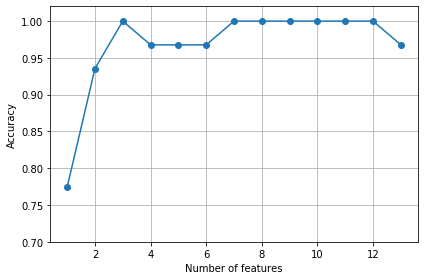

In [49]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# dobiera cechy
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# rysuje wykres wydajności podzbiorów cech
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Dokładność')
plt.xlabel('Liczba cech')
plt.grid()
plt.tight_layout()
# plt.savefig('rysunki/04_08.png', dpi=300)
plt.show()

In [50]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [51]:
knn.fit(X_train_std, y_train)
print('Dokładność dla danych uczących:', knn.score(X_train_std, y_train))
print('Dokładność dla danych testowych:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [52]:
knn.fit(X_train_std[:, k3], y_train)
print('Dokładność dla danych uczących:', knn.score(X_train_std[:, k3], y_train))
print('Dokładność dla danych testowych:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


<br>
<br>

# Ocenianie istotności cech za pomocą algorytmu losowego lasu

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


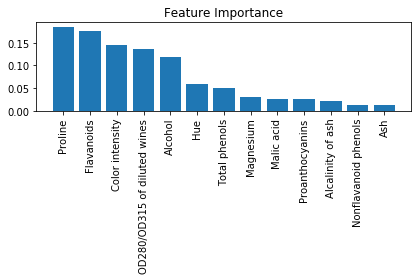

In [53]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Istotność cech')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('rysunki/04_09.png', dpi=300)
plt.show()

In [54]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Liczba cech spełniających dane kryterium progowe:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 5


Wyświetlmy teraz trzy cechy, które spełniły sformułowany powyżej warunek progowy doboru cech (poniższy fragment kodu nie jest obecny w książce, lecz został dodany do niniejszego notatnika w celach poglądowych):

In [55]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


# Podsumowanie

...

---

Czytelnicy mogą zignorować poniższą komórkę.

In [56]:
! python ../.convert_notebook_to_script.py --input r04.ipynb --output r04.py

[NbConvertApp] Converting notebook ch04.ipynb to script
[NbConvertApp] Writing 17120 bytes to ch04.py
